In [1]:
import numpy as np
import pandas as pd
import h5py
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, f1_score, roc_auc_score, plot_confusion_matrix, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold


def plot_av_data(dataset: pd.DataFrame, cols: int = 20) -> None:
    sns.heatmap(dataset.iloc[:, 0:cols].isnull())
    plt.show()


def load_data(train: bool = True) -> pd.DataFrame:
    if train:
        ds = "train"
    else:
        ds = "test"

    path = input(r"Input path to {} dataset (with name + .csv): ".format(ds))

    return pd.read_csv(path)


def preprocess_data(dataset: pd.DataFrame) -> tuple:
    create_target(dataset)
    df = drop_cases(dataset)
    df = drop_cols(df)
    return split_target_data(df)


def create_target(dataset: pd.DataFrame) -> None:
    """
    This function creates the target variable based on the prmdiag column

    Args:
        dataset: The dataset for which the target variable should be created

    Returns:
        None

    Raises:
        KeyError: ...
    """
    dataset["target"] = np.where((dataset['prmdiag'] == 2) | (dataset['prmdiag'] == 3), 1, 0)


def drop_cases(dataset: pd.DataFrame) -> pd.DataFrame:
    """
    Drops the observations of variable prmdiag with value 1 or 4

    Args:
        dataset: dataset on which the obs. should be dropped

    Returns:
        None

    Raises:
        KeyError: ...
    """
    return dataset.drop(dataset[(dataset["prmdiag"] == 1) | (dataset["prmdiag"] == 4)].index)


def drop_cols(dataset: pd.DataFrame, cols: set = ('ConnID', 'Repseudonym',
                                                  'siteid', 'visdat', 'IDs', "prmdiag")) -> pd.DataFrame:
    """
    Drops the columns which are not needed for further modelling

    Args:
        dataset: dataset on which the cols should be dropped
        cols:

    Returns:
        None

    Raises:
        KeyError: ...
    """
    return dataset.drop(columns=list(cols))


def split_target_data(dataset: pd.DataFrame) -> tuple:
    """
    splits the given dataset into target variable and features

    Args:
        dataset:

    Returns:
        None
    """

    y, x = dataset["target"], dataset.drop(columns="target")
    return y, x


def pred_evaluation(true: np.ndarray, preds: np.ndarray,
                    model: str = "Model") -> pd.DataFrame:
    """
    evaluates the given predictions

    Args:
        true:
        preds:
        model:

    Returns:
        Pandas Dataframe with several evaluation metrics

    Raises:
        KeyError: ...
    """

    accuracy = accuracy_score(true, preds)
    precision = precision_score(true, preds)
    recall = recall_score(true, preds)
    f1 = f1_score(true, preds)
    auc = roc_auc_score(true, preds)

    res = pd.DataFrame({"Accuracy": [accuracy],
                        "Precision": [precision],
                        "Recall": [recall],
                        "F1": [f1],
                        "AUC": [auc]})
    res.index = list(model) * len(res)
    return res


In [2]:
%%time
train = load_data(True)
test = load_data(False)
print(train.columns[:12])
train['prmdiag'].value_counts()
#plot_av_data(train)

Input path to train dataset (with name + .csv): C:\Users\leosc\OneDrive\Desktop\WiSe 21-22\Innolab\Test\train.csv
Input path to test dataset (with name + .csv): C:\Users\leosc\OneDrive\Desktop\WiSe 21-22\Innolab\Test\test.csv
Index(['ConnID', 'Repseudonym', 'siteid', 'age', 'visdat', 'sex', 'prmdiag',
       'edyears', 'MEM_score', 'Apoe', 'IDs', '1_2'],
      dtype='object')
Wall time: 1min 4s


1    283
0    181
2    124
3     80
4     59
Name: prmdiag, dtype: int64

In [3]:
y, X = preprocess_data(train)

In [4]:
print("column names: \t",list(train.columns[:12]))
print("shape:\t",train.shape)
print("prevalence:{:20.2f}%".format(y.mean()*100))
#looking at mean and sd of connectivity values based on target variable
#print(train.iloc[:,12:].groupby("target").mean().mean(axis = 1))
#print(train.iloc[:,12:].groupby("target").std().mean(axis = 1))


column names: 	 ['ConnID', 'Repseudonym', 'siteid', 'age', 'visdat', 'sex', 'prmdiag', 'edyears', 'MEM_score', 'Apoe', 'IDs', '1_2']
shape:	 (727, 30147)
prevalence:               52.99%


In [5]:
xg_class = xgb.XGBClassifier()

In [6]:
%%time
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=123)
n_scores = cross_val_score(xg_class, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print("CV Accuracy: {:.2f}".format(n_scores.mean()))

CV Accuracy: 0.89
Wall time: 5min 37s


In [7]:
print(n_scores)

[0.87179487 0.84615385 0.87179487 0.84615385 0.8974359  0.89473684
 0.89473684 0.86842105 0.97368421 0.92105263]


In [14]:
apprx_int = [n_scores.mean() - 2*np.std(n_scores), n_scores.mean() + 2*np.std(n_scores)] 
apprx_int

[0.8164265325547831, 0.9607664499013572]

In [8]:
%%time
xg_class.fit(X, y)

C:\Users\leosc\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:29:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 49.4 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [9]:
y_test, X_test = preprocess_data(test)

In [10]:
y_pred = xg_class.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print("Confusion Matrix:\n",cm)
print("Accuracy:\n", 1-np.sum(np.abs(y_pred - y_test))/len(y_test))

Confusion Matrix:
 [[35  2]
 [ 3 45]]
Accuracy:
 0.9411764705882353


In [11]:
pred_evaluation(y_test, y_pred, ["XGBoost"])

,Accuracy,Precision,Recall,F1,AUC
XGBoost,0.941176,0.957447,0.9375,0.947368,0.941723


C:\Users\leosc\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


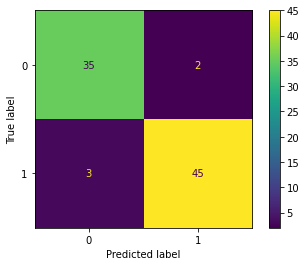

In [12]:
plot_confusion_matrix(xg_class, X_test, y_test)